# preprocessing tomato images(ripe / unripe)

Thực hiện tiền xử lý ảnh 

Cấu trúc:
- Cấu hình đường dẫn
- Kiểm tra số lượng ảnh ban đầu
- Hiện thị mẫu ảnh
- Hàm xử lý (resize, normalize, validate)
- Xử lý toàn bộ dataset
- Tạo báo cáo

In [1]:
import sys
print(sys.executable)

d:\HaUI\TTNT\project_tomato_16\project_tomato\.venv\Scripts\python.exe


In [2]:
# Imports và Config
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import pandas as pd

# === CONFIGURE THESE PATHS ===
BASE_DIR = Path(__file__).resolve().parent if "__file__" in locals() else Path.cwd().parent #Lấy đường dẫn Gốc

# Định nghĩa các thư mục chính
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = BASE_DIR / "processed_data"
SAVE_PROCESSED = True
IMAGE_SIZE = (224, 224) # quy dinh kich thuc cho anh

# Kiểm tra xác thực
DATA_DIR = Path(DATA_DIR)
PROCESSED_DIR = Path(PROCESSED_DIR)
assert DATA_DIR.exists(), f"DATA_DIR does not exist: {DATA_DIR}"

# Tạo thư mục đã xử lý nếu chưa có
if SAVE_PROCESSED:
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print('DATA_DIR =', DATA_DIR)
print('PROCESSED_DIR =', PROCESSED_DIR)
print('IMAGE_SIZE =', IMAGE_SIZE)
print('SAVE_PROCESSED =', SAVE_PROCESSED)






DATA_DIR = d:\HaUI\TTNT\project_tomato_16\project_tomato\data
PROCESSED_DIR = d:\HaUI\TTNT\project_tomato_16\project_tomato\processed_data
IMAGE_SIZE = (224, 224)
SAVE_PROCESSED = True


In [3]:
# Danh sách các nhóm và số lượng trong train/val/test
splits = ['train', 'val', 'test']
classes = set()
counts = []
for s in splits:
    p = DATA_DIR / s
    # print(p)
    row = {'split': s}
    if not p.exists():
        print('Warning: missing', p)
        continue
    for cls in sorted([d.name for d in p.iterdir() if d.is_dir()]):
        classes.add(cls)
        c = sum(1 for _ in (p/cls).glob('*') if (_).is_file())
        row[cls] = int(c)
    counts.append(row)
# Hiển thị bảng
df_counts = pd.DataFrame(counts).fillna(0)
numeric_cols = [c for c in df_counts.columns if c != 'split']
print('Classes detected:', sorted(list(classes)))
df_counts


Classes detected: ['riped', 'unriped']


,split,riped,unriped
0,train,199,195
1,val,97,80
2,test,97,80


--- train ---


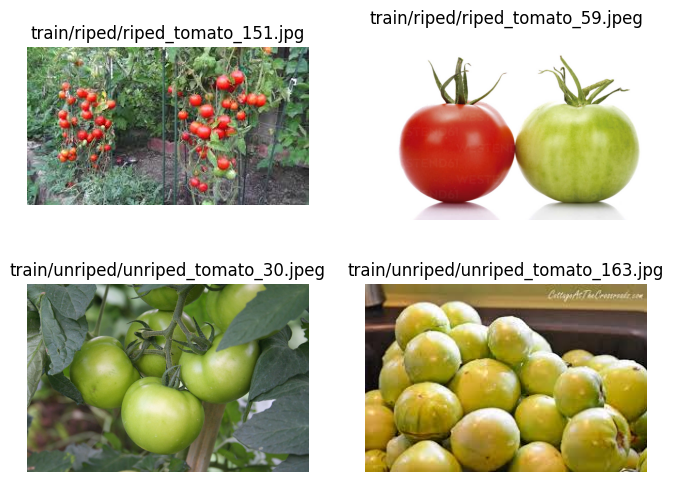

--- val ---


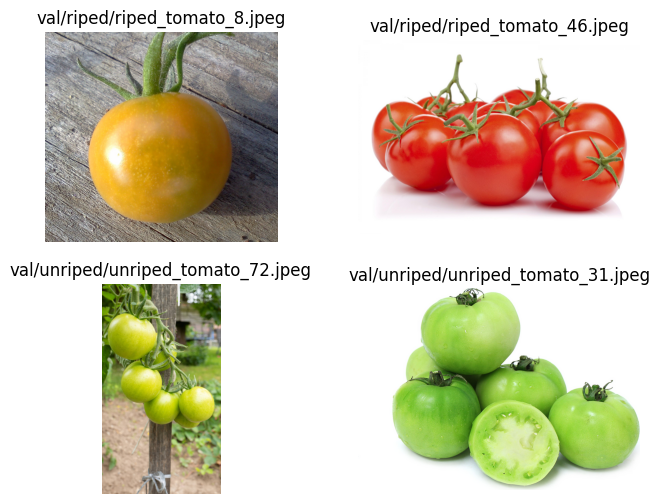

--- test ---


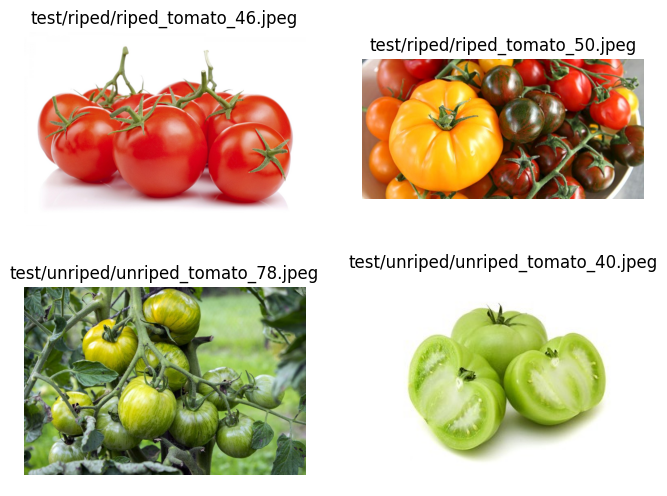

In [32]:
# Hiển Thị ảnh mẫu
import random

def show_samples(data_dir, split, classes, n_per_classes=2):
    fig_rows = len(classes)
    fig_cols = n_per_classes
    plt.figure(figsize=(4*fig_cols, 3*fig_rows))
    i = 1
    for cls in classes:
        folder = Path(data_dir)/split/cls
        imgs = [p for p in folder.glob('*') if p.is_file()]
        if len(imgs) == 0:
            continue
        sample = random.sample(imgs, min(n_per_classes, len(imgs)))
        for s in sample:
            img = cv2.imread(str(s))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(fig_rows, fig_cols, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{split}/{cls}/{s.name}")
            i += 1
    plt.show()

classes_sorted = sorted(list(classes))
for sp in splits:
    print('---', sp, '---')
    show_samples(DATA_DIR, sp, classes_sorted, n_per_classes=2)


In [30]:
# Preprocessing utilities: open, validate, resize, normalize, save
from PIL import Image
import traceback

def read_image(path):
    path = str(path)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        try:
            pil = Image.open(path).convert('RGB')
            return np.array(pil)
        except Exception as e:
            print(f"Cannot read (PIL) {path}: {e}")
            return None
        
    # If cv2 loads a grayscale image (1 channel) -> convert to 3-channel RGB
    if len(img.shape) == 2:  # grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        return img
    
    # If image has 4 channels (e.g., PNG with alpha)
    if img.shape[2] == 4:
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            return img
        except Exception:
            # fallback: drop alpha
            img = img[:, :, :3]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img
    
    # Normal 3-channel BGR -> convert to RGB
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    # Unexpected channel count
    print(f"Unsupported channel count ({img.shape}) for {path}")
    return None

def is_too_small(img, min_pixels=32*32):
    h, w = img.shape[:2]
    return (h*w) <min_pixels

def preprocess(img, size = IMAGE_SIZE, normalize=True):
    # img: RGB numpy array
    h, w = img.shape[:2]
    #resize
    img_resized = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    if normalize:
        img_resized = img_resized.astype('float32') / 255.0
    return img_resized

def save_image_uint8_safe(img_array, out_path, quality=95, global_report=None):
    out_path = Path(out_path)
    try:
        if img_array is None:
            raise ValueError("input image is None")

        arr = img_array  # local alias

        if arr.dtype == np.float32 or arr.dtype == np.float64:
            # guard against NaN/Inf
            arr = np.nan_to_num(arr, nan=0.0, posinf=255.0, neginf=0.0)
            arr = np.clip(arr * 255.0, 0, 255).astype('uint8')
        elif arr.dtype != np.uint8:
            # attempt conversion
            try:
                arr = arr.astype('uint8')
            except Exception as e:
                raise ValueError(f"Unsupported dtype and cannot convert: {arr.dtype} -> {e}")

        if arr.ndim == 2:
            # grayscale -> BGR
            try:
                arr_to_write = cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
            except Exception:
                arr_to_write = np.stack([arr]*3, axis=-1)
        elif arr.ndim == 3 and arr.shape[2] == 4:
            # RGBA or BGRA: drop alpha and convert RGB->BGR
            rgb = arr[:, :, :3]
            try:
                arr_to_write = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
            except Exception:
                # fallback: reverse channels if already BGR-like
                arr_to_write = rgb[:, :, ::-1]
        elif arr.ndim == 3 and arr.shape[2] == 3:
            # assume RGB -> convert to BGR
            try:
                arr_to_write = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
            except Exception:
                # fallback: maybe already BGR
                arr_to_write = arr
        else:
            raise ValueError(f"Unsupported image shape: {getattr(arr, 'shape', None)}")

        out_path.parent.mkdir(parents=True, exist_ok=True)

        ok = cv2.imwrite(str(out_path), arr_to_write)
        if ok:
            return True

        # fallback: try PIL saving
        try:
            from PIL import Image
            pil_arr = arr_to_write[:, :, ::-1]  # BGR -> RGB for PIL
            im = Image.fromarray(pil_arr)
            im.save(str(out_path), format='JPEG', quality=quality)
            return True
        except Exception as e_pil:
            raise IOError(f"cv2.imwrite returned False and PIL fallback failed: {e_pil}")

    except Exception as e:
        # Safe logging (không tham chiếu đến `arr` nếu nó chưa tồn tại)
        print(f"Error saving '{out_path}': {e}")
        try:
            # thêm thông tin debug hữu ích nếu có thể
            print(" - input type:", type(img_array))
            if isinstance(img_array, (np.ndarray,)):
                print(" - input dtype/shape:", getattr(img_array, 'dtype', None), getattr(img_array, 'shape', None))
        except Exception:
            pass
        traceback.print_exc(limit=1)
        # optional: ghi vào report chung nếu có
        try:
            if isinstance(global_report, dict):
                global_report.setdefault('errors', []).append({'path': str(out_path), 'error': str(e)})
        except Exception:
            pass
        return False


In [31]:
# Xử lý tất cả ảnh và lưu vào PROCESS_DIR nếu SAVE_PROCESSED==True
report = {'train':{}, 'val':{}, 'test':{}, 'errors':[]}

for sp in splits:
    src_split = DATA_DIR / sp
    dst_split = PROCESSED_DIR / sp
    if not src_split.exists():
        print('Skip missing', src_split)
        continue
    for cls in sorted([d.name for d in src_split.iterdir() if d.is_dir()]):
        src_folder = src_split / cls
        dst_folder = dst_split / cls
        dst_folder.mkdir(parents=True, exist_ok=True)
        
        imgs = [p for p in src_folder.glob('*') if p.is_file()]
        report[sp][cls] = {'total_before': len(imgs), 'processed': 0, 'skipped': 0}
        
        for p in tqdm(imgs, desc=f"Processing {sp}/{cls}"):
            img = read_image(p)
            if img is None:
                report['errors'].append({'path': str(p), 'error': 'cannot_read'})
                report[sp][cls]['skipped'] += 1
                continue
            if is_too_small(img):
                report['errors'].append({'path': str(p), 'error': 'too_small'})
                report[sp][cls]['skipped'] += 1
                continue
            out_name = p.stem + '.jpg'
            out_path = dst_folder / out_name

            # Nếu ảnh tồn tại thì bỏ qua
            if out_path.exists():
                report[sp][cls]['skipped'] += 1
                continue
            processed = preprocess(img, size=IMAGE_SIZE, normalize=True)
            # Save
            if SAVE_PROCESSED:
                ok = save_image_uint8_safe(processed, out_path, global_report=report)
                if not ok:
                    print("Failed to save:", out_path)
            report[sp][cls]['processed'] += 1
# Tóm tắt
print('Processing finished.')
# Số lượng mỗi lần chia tách sau khi xử lý (report)
rows = []
for sp in ['train', 'val', 'test']:
    for cls, info in report[sp].items():
        rows.append(
            {'split':sp, 'class':cls, 'total_before': info['total_before'], 'processed': info['processed'], 'skipped': info['skipped']}
        )
df_report = pd.DataFrame(rows)
df_report

Processing test/unriped: 100%|██████████| 80/80 [00:02<00:00, 34.46it/s]

Processing finished.


,split,class,total_before,processed,skipped
0,train,riped,199,199,0
1,train,unriped,195,195,0
2,val,riped,97,97,0
3,val,unriped,80,80,0
4,test,riped,97,97,0
5,test,unriped,80,80,0


In [ ]:
# Lưu report JSON + CSV
(PROCESSED_DIR).mkdir(parents=True, exist_ok=True)
with open(PROCESSED_DIR / 'report.json','w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

df_report.to_csv(PROCESSED_DIR / 'report.csv', index=False)
print('Reports saved to', PROCESSED_DIR)

# Hiển thị một vài ảnh 
for sp in splits:
    for cls in classes_sorted:
        folder = PROCESSED_DIR / sp / cls
        if folder.exists():
            samples = list(folder.glob('*'))[:3]
            if len(samples)==0:
                continue
            plt.figure(figsize=(8,3))
            for i,s in enumerate(samples):
                img = read_image(s)
                if img is None:
                    continue
                img_proc = preprocess(img, size=IMAGE_SIZE, normalize=False)  # show in 0-255
                plt.subplot(1, len(samples), i+1)
                plt.imshow(img_proc.astype('uint8'))
                plt.axis('off')
            plt.suptitle(f"Processed samples: {sp}/{cls}")
            plt.show()
            break
